<a href="https://colab.research.google.com/github/jasonwashburn/ColabNotebooks/blob/main/06_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File Setup

In [1]:
!cp "/content/drive/MyDrive/Colab Notebooks/SpamData.zip" ./
!unzip SpamData > unzip.log

# Imports

In [2]:
from os import walk
from os.path import join
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

%matplotlib inline

## Constants

In [3]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"

In [4]:
print(SPAM_1_PATH)

SpamData/01_Processing/spam_assassin_corpus/spam_1


## Reading Files

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [7]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True

stream.close()

#email_body = "\n".join(lines)
#print(email_body)

print(lines)

['\n', 'Dear Mr Still\n', '\n', 'Good tidings to you and all your staff for the festive season ahead (Christmas).\n', 'Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa\'s Grotto" in your store.\n', 'But WAIT! You\'re probably thinking: "What makes him so special?"\n', 'Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.\n', 'You will note also, from the enclosed sketch, that I have radically redesigned Santa\'s outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.\n', 'I look forward to hearing from you.\n', '\n', 'Best wishes\n', 'Robin C

# Generator Functions

In [8]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [9]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [10]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):

        for file_name in filenames:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True

            stream.close()

            email_body = "\n".join(lines)
            
            yield file_name, email_body

In [11]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

spam_emails.head()

,MESSAGE,CATEGORY
00093.ca4edc32d2ff8e1dbb5f9c0b15ec435b,Get your favorite Poker action at http://www.m...,1
00050.45de99e8c120fddafe7c89fb3de1c14f,<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...,1
00022.8203cdf03888f656dc0381701148f73d,--===_SecAtt_000_1fheucnqggtggp\n\nContent-Typ...,1
00408.22230b84aee00e439ae1938e025d5005,"\n\n<html>\n\n<body bgcolor=""#FFFFFF"">\n\n<TAB...",1
00364.11dba84b95e0471927d1ebc8ff0017ef,"<META HTTP-EQUIV=""Content-Type"" CONTENT=""text/...",1


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()

,MESSAGE,CATEGORY
02351.d6b3bc2bb32bd4a790e07be3bc9c8bb0,URL: http://boingboing.net/#85534163\n\nDate: ...,0
01945.68b0cc1d272dc3bc3bffcb3112379650,URL: http://www.mozillazine.org/weblogs/hyatt/...,0
01429.6d9cae984e2f92f32d70594f5cc37c87,http://www.hughes-family.org/bugzilla/show_bug...,0
01193.5b3aa2609dfb823e754b1407d451f97f,"Once upon a time, Thomas wrote :\n\n\n\n> > On...",0
01468.a68ebe03295c662d692e89930e88d07e,This is a multi-part message in MIME format.\n...,0


In [15]:
ham_emails.shape

(3901, 2)

In [16]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is ", data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00093.ca4edc32d2ff8e1dbb5f9c0b15ec435b,Get your favorite Poker action at http://www.m...,1
00050.45de99e8c120fddafe7c89fb3de1c14f,<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...,1
00022.8203cdf03888f656dc0381701148f73d,--===_SecAtt_000_1fheucnqggtggp\n\nContent-Typ...,1
00408.22230b84aee00e439ae1938e025d5005,"\n\n<html>\n\n<body bgcolor=""#FFFFFF"">\n\n<TAB...",1
00364.11dba84b95e0471927d1ebc8ff0017ef,"<META HTTP-EQUIV=""Content-Type"" CONTENT=""text/...",1


# Data Cleaning: Checking for Missing Values

In [17]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [18]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [19]:
(data.MESSAGE.str.len() == 0).sum()

3

### Locate empty emails

In [20]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [21]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from Dataframe

In [22]:
data.drop(['cmds'], inplace=True)

In [23]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [24]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [25]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,Get your favorite Poker action at http://www.m...,1,00093.ca4edc32d2ff8e1dbb5f9c0b15ec435b
1,<html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...,1,00050.45de99e8c120fddafe7c89fb3de1c14f
2,--===_SecAtt_000_1fheucnqggtggp\n\nContent-Typ...,1,00022.8203cdf03888f656dc0381701148f73d
3,"\n\n<html>\n\n<body bgcolor=""#FFFFFF"">\n\n<TAB...",1,00408.22230b84aee00e439ae1938e025d5005
4,"<META HTTP-EQUIV=""Content-Type"" CONTENT=""text/...",1,00364.11dba84b95e0471927d1ebc8ff0017ef


In [26]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,-----BEGIN PGP SIGNED MESSAGE-----\n\nHash: SH...,0,00564.5d9d3d4ebddcd338604ae63d5b01f037
5792,"On Sun, 21 Jul 2002 15:12:11 -0400, che <che66...",0,01147.d239448a535755047478e750e99c64b7
5793,\n\nIs there a relatively clean way to dynamic...,0,00682.ed1e8972923a1eb98875e4a2b87f6f60
5794,"On Fri 19 Jul 2002 12:41, Wynne, Conor wrote:\...",0,00027.c9e76a75d21f9221d65d4d577a2cfb75
5795,"On 12/08/02 22:38 -0400, Sven wrote:\n\n) \n\n...",0,00628.f03f3008b1f1621e0df41f75d5ffcd58


# Save to File using Pandas

In [27]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [28]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [29]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

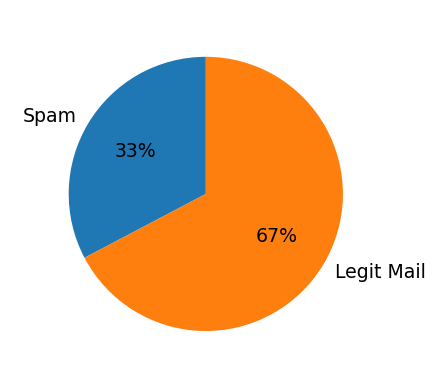

In [30]:
category_names = ['Spam', "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%')
plt.show()

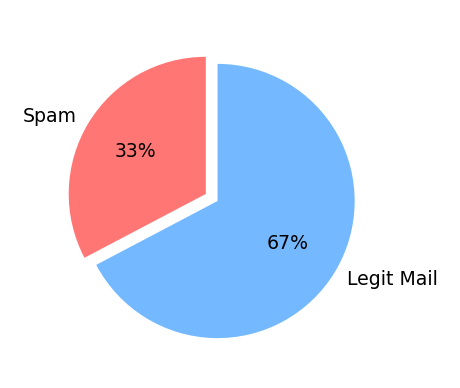

In [31]:
custom_colors=['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

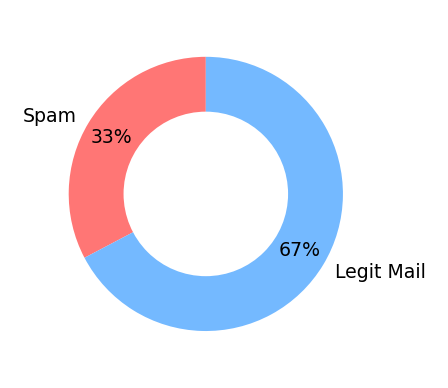

In [32]:
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

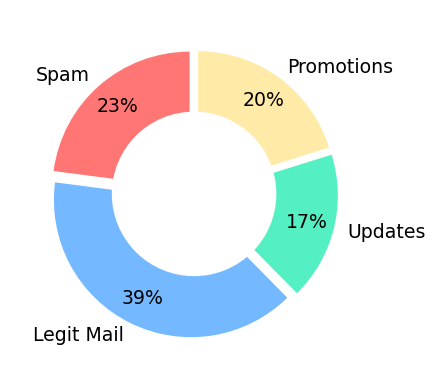

In [33]:
category_names = ['Spam', "Legit Mail", 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors=['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing

### Text Pre-Processing

In [34]:
# convert to lower case
msg = "All work and no play makes Jack a dull boy."
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Tokenizing

In [37]:
msg = "All work and no play makes Jack a dull boy."
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [38]:
stop_words = set(stopwords.words('english'))
type(stop_words)

set

In [39]:
if 'this' in stop_words: print('Found it!')

Found it!


In [40]:
if 'hello' not in stop_words: print('Nope, not in here!')

Nope, not in here!


In [41]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())

filtered_words = [word for word in words if word not in stop_words]
filtered_words


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

## Word Stems and Stemming

In [42]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing Punctuation

In [43]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


# Removing HTML tags from Emails

In [44]:
soup = BeautifulSoup(data.at[1, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
 </head>
 <body>
  <center>
   <font color='3D"#000000"' face='3D"times"' size='3D"6"'>
    Save up to
    <font color='3D"#ff0000"'>
     75%
    </font>
    on your Term Life

Insurance!
   </font>
   <br/>
   <font color='3D"#000000"' face='3D"times"' size='3D"4"'>
    <i>
     Compare rates from top insurance companies around

the country
    </i>
   </font>
   <br/>
   <br/>
   <font color='3D"#7084D6"' face='3D"arial"' size='3D"4"'>
    <b>
     In our life and times, it's important to plan for

your family's future, while
     <br/>
     being comfortable financially.  Choose the right

Life Insurance policy today.
    </b>
   </font>
   <p>
    <font color='3D"#000000"' face='3D"arial"' size='3D"3"'>
     <i>
      Click the link below to compare the lowest rates

and save up to
      <font color='3D"#ff0000"'>
       75%
      </font>
     </i>
    </font>
   </p>
  </center>
 </body>
</html>
<p>
 <a href='3D"http://insurancequotesource.com/user0202/termquotes/4

In [45]:
soup.get_text()

"\n\n\n\n\nSave up to\n\n\n\n75% on your Term Life\n\nInsurance!\n\n\nCompare rates from top insurance companies around\n\nthe country\n\n\nIn our life and times, it's important to plan for\n\nyour family's future, while \n\nbeing comfortable financially.  Choose the right\n\nLife Insurance policy today.\n\n\nClick the link below to compare the lowest rates\n\nand save up to 75%\n\n\nCOMPARE YOUR COVERAGE\n\n\n\nYou'll be able to compare rates and get a free\n\napplication in less than a minute!\n\n\n*Get your FREE instant quotes...\n\n*Compare the lowest prices, then...\n\n*Select a company and Apply Online.\n\n\nGET A FREE QUOTE NOW!\n\n\nYou can't predict the future, but you can always\n\nprepare for it.\n\n\nto be\n\nexcluded from future contacts \n\n\n\ngraham_adlam\n\n\n\n\n\n\n\n\n\n\n"

## Functions for Email Processing

In [46]:
def clean_message(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha:
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [47]:
def clean_message_no_html(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    soup = BeautifulSoup(message, 'html.parser')
    words = word_tokenize(soup.get_text().lower())
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [48]:
clean_message_no_html(data.at[2, 'MESSAGE'])

['urgent',
 'privat',
 'extrem',
 'confidenti',
 'dear',
 'profound',
 'interest',
 'utmost',
 'solicit',
 'immedi',
 'assist',
 'enabl',
 'us',
 'round',
 'opportun',
 'within',
 'capabl',
 'result',
 'death',
 'one',
 'contractor',
 'surpris',
 'got',
 'highli',
 'recommend',
 'believ',
 'trustworthi',
 'bello',
 'chief',
 'special',
 'project',
 'foreign',
 'contract',
 'regular',
 'offic',
 'auditor',
 'gener',
 'feder',
 'feder',
 'republ',
 'work',
 'hand',
 'senat',
 'committe',
 'foreign',
 'contract',
 'duti',
 'ensur',
 'contractor',
 'paid',
 'contract',
 'sum',
 'due',
 'last',
 'payment',
 'total',
 'contractor',
 'short',
 'list',
 'payment',
 'paid',
 'remain',
 'inform',
 'reach',
 'offic',
 'indic',
 'one',
 'among',
 'remain',
 'report',
 'name',
 'gerrand',
 'schwartz',
 'die',
 'last',
 'air',
 'franc',
 'concord',
 'plane',
 'meanwhil',
 'finish',
 'execut',
 'contract',
 'decemb',
 'sinc',
 'nobodi',
 'come',
 'forward',
 'put',
 'claim',
 'contract',
 'fund',
 'u

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [53]:
data.iat[2,2]

'00022.8203cdf03888f656dc0381701148f73d'

In [56]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT...,1,00350.c2658f17a328efdf045b38ab38db472f
6,"WERKEN BIJ DE LOTTO,\n\n41132, NL-1007 DB AMST...",1,00362.be7a346be8746732d4dc27bc549d7441
7,"<HTML>\n\n<BODY>\n\n<meta http-equiv=""Content-...",1,00300.834f370a21ca4f1774d5724b5443411c
8,"Mr.Vincent Nnaji,\n\n Standard Trust Bank Ltd,...",1,00465.ca5d79d0e5dadee322c117789196ebb4
9,*** FREE BONUS OFFER - SEE BELOW ***\n\n\n\nWe...,1,00301.68fe7955b96d085360ca916289e8e716
10,------000000000000000000000\n\nContent-Type: t...,1,00334.a1038f98abb76b403d068afb57bfb290


In [60]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message_no_html)

In [62]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

342

In [63]:
%%time
# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message_no_html)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


CPU times: user 35.7 s, sys: 81.5 ms, total: 35.8 s
Wall time: 35.9 s


In [64]:
nested_list.head()

DOC_ID
0    [get, favorit, poker, action, http, play, real...
1    [save, term, life, insur, compar, rate, top, i...
2    [urgent, privat, extrem, confidenti, dear, pro...
3    [team, foundmoney, help, locat, claim, lost, c...
4    [chase, receiv, mail, member, subscrib, jm, un...
Name: MESSAGE, dtype: object

In [65]:
nested_list.tail()

DOC_ID
5791    [pgp, sign, messag, hash, friday, august, la, ...
5792    [sun, jul, che, wrote, server, mention, work, ...
5793    [rel, clean, way, dynam, build, comp, file, ba...
5794    [fri, jul, wynn, conor, wrote, long, look, lik...
5795    [sven, wrote, timeout, hardcod, plan, right, m...
Name: MESSAGE, dtype: object

### Using Logic to Slice DataFrames

In [66]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [68]:
data[data.CATEGORY == 1].tail

<bound method NDFrame.tail of                                                   MESSAGE  ...                               FILE_NAME
DOC_ID                                                     ...                                        
0       Get your favorite Poker action at http://www.m...  ...  00093.ca4edc32d2ff8e1dbb5f9c0b15ec435b
1       <html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...  ...  00050.45de99e8c120fddafe7c89fb3de1c14f
2       --===_SecAtt_000_1fheucnqggtggp\n\nContent-Typ...  ...  00022.8203cdf03888f656dc0381701148f73d
3       \n\n<html>\n\n<body bgcolor="#FFFFFF">\n\n<TAB...  ...  00408.22230b84aee00e439ae1938e025d5005
4       <META HTTP-EQUIV="Content-Type" CONTENT="text/...  ...  00364.11dba84b95e0471927d1ebc8ff0017ef
...                                                   ...  ...                                     ...
1891    \n\n*** Compliance: see notice at bottom of ma...  ...  00125.ea96729a0da6d9025d5178f2d6916e42
1892    Dear Sirs,\n\nWe know your esteemed

In [70]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting A Series with an Index

In [71]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [74]:
nested_list_ham.shape

(3900,)

In [75]:
nested_list_ham.tail()

DOC_ID
5791    [pgp, sign, messag, hash, friday, august, la, ...
5792    [sun, jul, che, wrote, server, mention, work, ...
5793    [rel, clean, way, dynam, build, comp, file, ba...
5794    [fri, jul, wynn, conor, wrote, long, look, lik...
5795    [sven, wrote, timeout, hardcod, plan, right, m...
Name: MESSAGE, dtype: object

In [76]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [85]:
flat_list_ham = [word for sublist in nested_list_ham for word in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20744

In [86]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [89]:
flat_list_spam = [word for sublist in nested_list_spam for word in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the non-spam messages

13280

In [90]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64